# Xe Propellant Storage
Can MOFs confer a benefit for storing Xe? For applications as propellant for a spacecraft, the goal is to minimize the total mass carried into space. To contrast, this mass is composed of:
* for compressed Xe (`cXe`) storage (no MOF, a free-space tank): the xenon needed and the material that composes the tank
* for adsorbed Xe (`aXe`) storage (a tank packed with MOF): the xenon needed, the material that composes the tank *and* the adsorbent material.

The idea is that we can reduce the mass of tank material needed by reducing the storage pressure needed to achieve a given density of Xe. This necessitates us to carry extra mass, the mass of the MOF, though. The question is whether the reduced mass of the tank material outweighs the extra mass of this adsorbent material we need to carry into space.

In [1]:
using PyPlot
using PorousMaterials
using CSV
using DataFrames
using JSON

PyPlot.matplotlib.style.use("Solarize_Light2")
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

16

temperature `T` in the atmosphere

In [2]:
const T = 298.0 # K

298.0

universal gas constant

In [3]:
const R = 8.3144598e-5 # m³-bar/(K-mol)

8.3144598e-5

Mass desired of xenon propellant. [Source](https://doi.org/10.2514/6.2000-3677) for typical amount of Xe to bring into space: 89 kg

In [4]:
const mol_desired_propellant = 1000 # mol

1000

range of storage pressures considered

In [5]:
const P = 10 .^ range(-2.0, stop=log10(200.), length=501)[2:end]; # bar

properties of the tank material

We model the pressure vessel as a thin-walled pressure vessel.

We list the density `ρ` and yield strength `σ` of the tank material below.

In [6]:
# # Kevlar 49 Source: http://www.mse.mtu.edu/~drjohn/my4150/props.html
# const ρ_tank_material = 1470.0 # kg/m³
# const σ_tank_material = 28000.0 # bar

# titanium
const ρ_tank_material = 4506.0 # kg/m³
const σ_tank_material = 1400.0 # bar

1400.0

## Compressed xenon (`cXe`) storage
we model xenon with the van der Waals equation of state. We first explore how the van der Waals gas differs from the ideal gas.

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = VdWFluid(::Symbol) at EOS.jl:151
└ @ PorousMaterials /home/cokes/.julia/dev/PorousMaterials/src/EOS.jl:151
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = VdWFluid(::Symbol) at EOS.jl:154
└ @ PorousMaterials /home/cokes/.julia/dev/PorousMaterials/src/EOS.jl:154


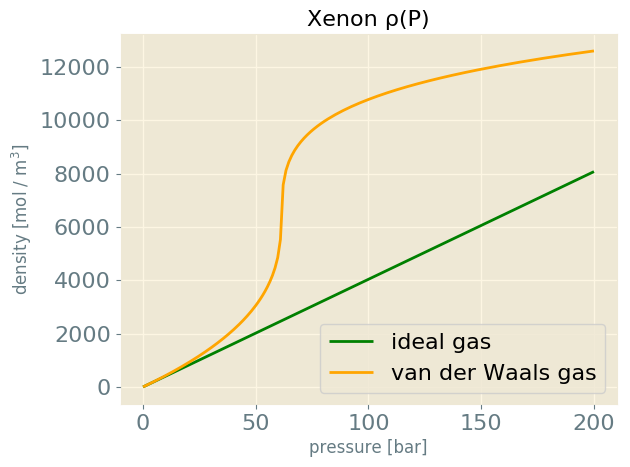

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = VdWFluid(::Symbol) at EOS.jl:155
└ @ PorousMaterials /home/cokes/.julia/dev/PorousMaterials/src/EOS.jl:155


PyObject Text(0.5, 1.0, 'Xenon ρ(P)')

In [7]:
# ideal gas density
ρ_ideal_gas = P / (R * T) # mol / m³

ρ_vdw_gas = zeros(length(P))
xe = VdWFluid(:Xe)

for (i, p_i) in enumerate(P)
    props = calculate_properties(xe, T, p_i, verbose=false)
    ρ_vdw_gas[i] = props["density (mol/m³)"]
end
    
figure()
plot(P, ρ_ideal_gas, color="green", label="ideal gas")
plot(P, ρ_vdw_gas, color="orange", label="van der Waals gas")
xlabel("pressure [bar]")
ylabel("density [mol / m\$^3\$]")
legend()
title("Xenon ρ(P)")
#savefig("Xenon Ideal Gas vs. van der Waals Gas Density.pdf", format="pdf")

The volume of the tank must be equal to the volume of propellant (of course). Since we have the density of the propellant at each pressure, we thus know the volume of the tank at each choice of storage pressure.

In [8]:
V_cXe_tank = mol_desired_propellant ./ ρ_vdw_gas; # m³

Assuming the tank is spherical, we can calculate the radius of the tank for each choice of storage pressure.

In [9]:
r_cXe_tank = (V_cXe_tank * 3 / (4 * π)) .^ (1 / 3); # m

We apply the thin-walled tank stress model to obtain the minimum wall thickness required to contain the pressure of the compressed xenon. Thickness is found using the free-body diagram of a spherical, thin-walled tank. By taking the force of the fluid over a cross-sectional area ($P \pi  r ^ 2$) set equal to the force of the tank walls over the circumference, including the yield strength and thickness of the wall ($2 \pi  r \sigma  t$). We then isolate $t$ to solve for the thickness.

\begin{equation}
2 \pi  r \sigma  t=P \pi  r ^ 2
\end{equation}

In [10]:
t_cXe_tank = P .* r_cXe_tank / (2 * σ_tank_material); # tank wall thickness (m)

The mass of the tank can be found using the surface area of sphere, the thickness of the sphere, and the density of the material.

In [11]:
m_cXe_tank_material = ρ_tank_material * 4 * π * r_cXe_tank .^ 2 .* t_cXe_tank; # kg

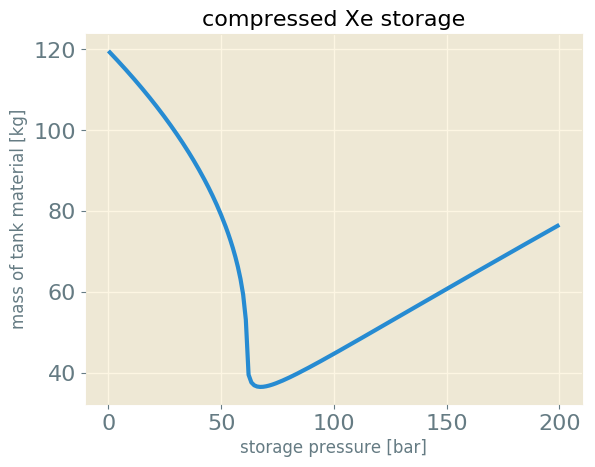

PyObject Text(0.5, 1.0, 'compressed Xe storage')

In [12]:
figure()
plot(P, m_cXe_tank_material, color="C0", lw=3)
xlabel("storage pressure [bar]")
ylabel("mass of tank material [kg]")
#legend()
title("compressed Xe storage")
#savefig("Xenon van der Waals Gas in Pure Kevlar 49.pdf", format="pdf")

NOTE: this is using PURE Kevlar 49. Titanium is typically used only as an inner lining with carbon fiber overwrapping* -- [Source](https://doi.org/10.2514/6.2000-3677)
Kevlar 49 is used as 80-90% of the structural integrity of the tank while the lining makes direct contact with the compressed fluid. The lining does provide structural support, but very little compared to the overwrap.

## Adsorbed xenon `aXe` storage

consider SBMOF-1 as the adsorbent.

find its crystal density.

In [13]:
frame = Framework("SBMOF-1_cory.cif")
strip_numbers_from_atom_labels!(frame)
const ρ_MOF = crystal_density(frame) # kg/m³

1570.4004025492634

read in xenon adsorption data.

In [14]:
df_MOF = CSV.read(joinpath(pwd(), "data", "isotherms", "SBMOF-1_298K.csv"))
df_MOF[!, :bar] = df_MOF[!, Symbol("P(mbar)")] / 1000 # bar
# mass % = (measured mass -  dry sample mass) / (dry sample mass) * 100.
# (g Xe / g MOF) * (1000 g MOF/ 1 kg MOF) * (ρ_MOF kg MOF/m³ MOF) * (1 mol Xe/ MW g Xe)
df_MOF[!, :mol_m3] = df_MOF[!, :PercentMass] / 100.0 * 1000.0 * ρ_MOF / read_atomic_masses()[:Xe] # mol Xe/m³ MOF  
df_MOF

,P(mbar),Weight(mg),PercentMass,bar,mol_m3
,Float64,Float64,Float64,Float64,Float64
1,0.063,36.4861,4.0e-6,6.3e-5,0.000478441
2,0.222,36.4888,0.007839,0.000222,0.937626
3,0.398,36.51,0.066458,0.000398,7.94907
4,0.58,36.5438,0.159596,0.00058,19.0893
5,0.803,36.5881,0.281799,0.000803,33.7061
6,0.985,36.6281,0.392194,0.000985,46.9105
7,4.966,37.4443,2.64343,0.004966,316.182
8,9.976,38.298,4.99974,0.009976,598.021
9,19.99,39.4357,8.14745,0.01999,974.519


In [15]:
# # filter through units with Arni l8er
# global PATH_TO_DATA = joinpath(pwd(), "data")

# function isotherm_data(isotherm_filename::AbstractString)
#     file = open(joinpath(PATH_TO_DATA, "isotherms", isotherm_filename))
#     lines = readlines(file)
#     close(file)
#     data = JSON.parse(join(lines))
    
#     pressure_pts = Array{Float64,1}()
#     adsorption_pts = Array{Float64,1}()

#     for datapoints_dict in data["isotherm_data"]
#         append!(pressure_pts, datapoints_dict["pressure"])
#         append!(adsorption_pts, datapoints_dict["total_adsorption"])
#     end

#     df_isotherm = Dict{Symbol, Array{Float64}}()
#         df_isotherm[Symbol("P(bar)")] = pressure_pts
#         df_isotherm[Symbol("Adsorption(mmol/g)")] = adsorption_pts
#     DataFrame(df_isotherm)
# end

In [16]:
# df = isotherm_data("10.1016j.micromeso.2012.11.013.isotherm1.json")

density of the adsorbent

In [17]:
# # TODO what MOF?
# const ρ_mof = 555.0 # kg/m³

In [18]:
# df[!, :mol_m3] = df[!, Symbol("Adsorption(mmol/g)")] * ρ_mof
# showall(df)

Using the function `fit_adsorption_isotherm` from Porous Materials, we calculated `M`, the density of gas in the MOF at saturation, and the Langmuir constant `K`. The Langmuir adsorption model for the loading `L` is:
\begin{equation}
L = M KP/(1+KP)
\end{equation} 
The Langmuir model was then fitted to the experimental data and the root mean square was calculated, showing how good of a fit the model is to the experimental data. 

In [19]:
params_langmuir = fit_adsorption_isotherm(copy(df_MOF), :bar, :mol_m3, :langmuir)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = fit_adsorption_isotherm(::DataFrame, ::Symbol, ::Symbol, ::Symbol) at Misc.jl:193
└ @ PorousMaterials /home/cokes/.julia/dev/PorousMaterials/src/Misc.jl:193
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = fit_adsorption_isotherm(::DataFrame, ::Symbol, ::Symbol, ::Symbol) at Misc.jl:194
└ @ PorousMaterials /home/cokes/.julia/dev/PorousMaterials/src/Misc.jl:194
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = _guess(::DataFrame, ::Symbol, ::Symbol, ::Symbol) at Misc.jl:143
└ @ PorousMaterials /home/cokes/.julia/dev/PorousMaterials/src/Misc.jl:143
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = _guess(::DataFrame, ::Symbol, ::Symbol, ::Symbol) at Misc.jl:144
└ @ PorousMat

Dict{String,Float64} with 3 entries:
  "M"   => 2217.01
  "K"   => 37.2343
  "MSE" => 489.714

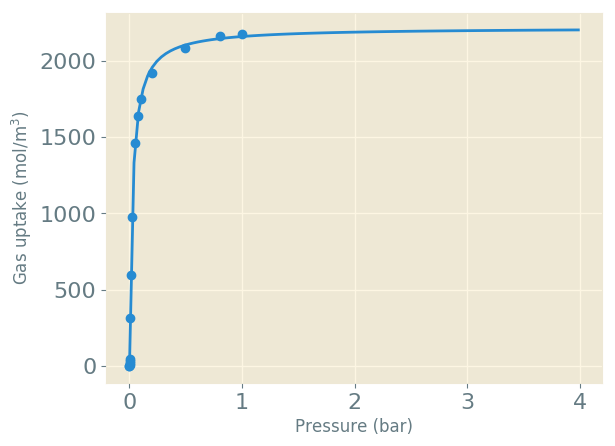

PyObject Text(34.10000000000001, 0.5, 'Gas uptake (mol/m$^3$)')

In [20]:
P_fit = range(0.0, stop=4.0, length=100)
N_fit = params_langmuir["M"] * params_langmuir["K"] .* P_fit ./ (1 .+ params_langmuir["K"] .* P_fit)

fig = figure()
scatter(df_MOF[!, :bar], df_MOF[!, :mol_m3])
plot(P_fit, N_fit)
xlabel("Pressure (bar)")
ylabel(L"Gas uptake (mol/m$^3$)")

In [21]:
function ρ_Langmuir(P::Array{Float64}, K::Float64, M::Float64)
    return M * K .* P ./ (1 .+ K .* P)
end

ρ_Langmuir (generic function with 1 method)

In [22]:
ρ_fluid_MOF = ρ_Langmuir(collect(P), params_langmuir["K"], params_langmuir["M"]); # mol/m³

The volume of the tank storing the MOF is equal to the volume of the MOF required to store the desired amount of propellant.

In [23]:
V_aXe_tank = mol_desired_propellant ./ ρ_fluid_MOF; # m³

Find the corresponding radius of the vessel, assumed spherical.

In [24]:
r_aXe_tank = (V_aXe_tank * 3 / (4 * π)) .^ (1 / 3); # m

Mass of MOF needed to carry desired amount of gas.

In [25]:
m_MOF_needed = V_aXe_tank * ρ_MOF; # kg

Using thin-walled theory, the thickness of the wall of the container storing the mof is equal to the pressure multiplied by the radius of the container divided by two times the tensile strength of the container material. 
\begin{equation}
t_{tank with mof} = P r_{tank with mof} / 2\sigma
\end{equation} 


In [26]:
t_aXe_tank = P .* r_aXe_tank / (2 * σ_tank_material); # m

In [27]:
m_aXe_tank_material = 4 * π * r_aXe_tank .^ 2 .* t_aXe_tank * ρ_tank_material; # kg 

The total mass of the tank and MOF for the desired amount of propellant is equal to the mass of the MOF required to store the desired amount of propellant, plus the mass of the thin-walled tank storing the MOF.

In [28]:
m_aXe_tank = m_MOF_needed .+ m_aXe_tank_material; # kg

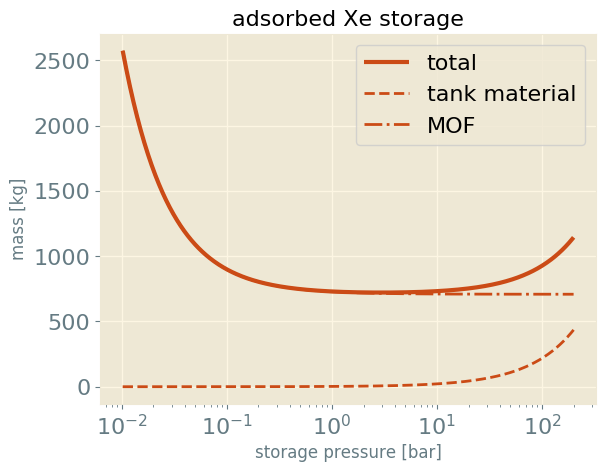

PyObject <matplotlib.legend.Legend object at 0x7f8efa525ac8>

In [33]:
figure()
plot(P, m_aXe_tank, color="C4", lw=3, label="total")
plot(P, m_aXe_tank_material, color="C4", label="tank material", linestyle="--")
plot(P, m_MOF_needed, color="C4", label="MOF", linestyle="-.")
xlabel("storage pressure [bar]")
ylabel("mass [kg]")
title("adsorbed Xe storage")
ax = gca()
ax.set_xscale("log")
legend()

## juxtapose compressed vs adsorbed xenon storage

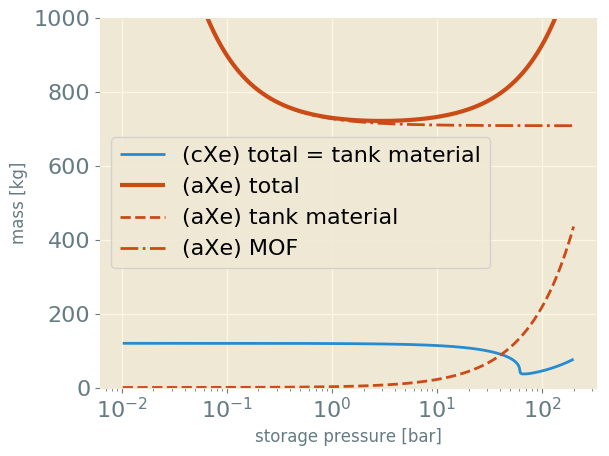

In [34]:
figure()
plot(P, m_cXe_tank_material, color="C0", label="(cXe) total = tank material")

plot(P, m_aXe_tank, color="C4", lw=3, label="(aXe) total")
plot(P, m_aXe_tank_material, color="C4", label="(aXe) tank material", linestyle="--")
plot(P, m_MOF_needed, color="C4", label="(aXe) MOF", linestyle="-.")

xlabel("storage pressure [bar]")
ylabel("mass [kg]")
ax = gca()
ax.set_xscale("log")
ylim(0, 1000)
legend()
display()

In [35]:
minimum_mass_index = argmin(m_aXe_tank)

287

In [36]:
df_minimum = Dict("Min pressure (bar)" => P[minimum_mass_index], 
                  "Min radius (m)" => r_aXe_tank[minimum_mass_index],
                  "Min thickness (m)" => t_aXe_tank[minimum_mass_index], 
                  "Min volume (L)" => V_aXe_tank[minimum_mass_index],
                  "Min mass of mof (kg)" => m_MOF_needed[minimum_mass_index],
                  "Min mass of tank with mof (kg)" => m_aXe_tank[minimum_mass_index])
df_minimum

Dict{String,Float64} with 6 entries:
  "Min volume (L)"                 => 0.455175
  "Min thickness (m)"              => 0.000501568
  "Min pressure (bar)"             => 2.94301
  "Min radius (m)"                 => 0.477196
  "Min mass of tank with mof (kg)" => 721.274
  "Min mass of mof (kg)"           => 714.807

Optimum may come from saturation point of material.
It seems that the MOF used to store the desired amount of propellant saturate very early on. The pressure range we test at is far to great compared to the isotherm data (which typically range from 0-10bar).
